# Loveida Lucero

# Gridsearch (Practice)
We will continue working with the energy consumption dataset from the previous practice with the goal of predicting the next 24 monhs of energy consumption. You can continue working in the same notebook from the previous practice.

For reference, you can access the data [here](https://drive.google.com/file/d/1IClDcGLYysTkFEOeSTYplNvxJgrk9wzL/view?usp=sharing)​.  ([Original Source](https://github.com/jenfly/opsd)​)

- We will look at the "Consumption" column for our time series.
- Convert the Date column to datetime and make it the index.
- Resample the data to a monthly frequency calculated with the mean.
- Check for and address missing values.
- Plot the time series.

Your task,

In the previous practice, we tried an initial seasonal model. While it outperformed the nonseasonal model, we will now use auto arima to try alternative model orders for a seasonal model and decide on a final model.

- Tune with pmdarima's auto_arima
- Fit a model on training data with the best parameters from auto_arima
- Plot the forecasts versus the test data
- Obtain metrics for evaluation
- Make forecasts with the auto_arima model
- Select a final model

# SOLUTION

**Imports**

In [1]:
#Installed in previous notebook
#!pip install pmdarima

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs

**Custom Functions**

In [3]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [4]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()
    
    return fig

In [5]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

**Load Data**

In [7]:
df = pd.read_csv('Data/opsd_germany_daily.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4383 entries, 0 to 4382
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         4383 non-null   object 
 1   Consumption  4383 non-null   float64
 2   Wind         2920 non-null   float64
 3   Solar        2188 non-null   float64
 4   Wind+Solar   2187 non-null   float64
dtypes: float64(4), object(1)
memory usage: 171.3+ KB


,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.184,NaN,NaN,NaN
1,2006-01-02,1380.521,NaN,NaN,NaN
2,2006-01-03,1442.533,NaN,NaN,NaN
3,2006-01-04,1457.217,NaN,NaN,NaN
4,2006-01-05,1477.131,NaN,NaN,NaN


In [8]:
# Make the date column a datetime object and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df.index

DatetimeIndex(['2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04',
               '2006-01-05', '2006-01-06', '2006-01-07', '2006-01-08',
               '2006-01-09', '2006-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=4383, freq=None)

In [9]:
# resample to a monthly frequency with mean
df = df.resample('M').mean()

In [10]:
# define the ts as consumtion 
ts = df['Consumption']

In [11]:
# Check for null values
ts.isna().sum()

0

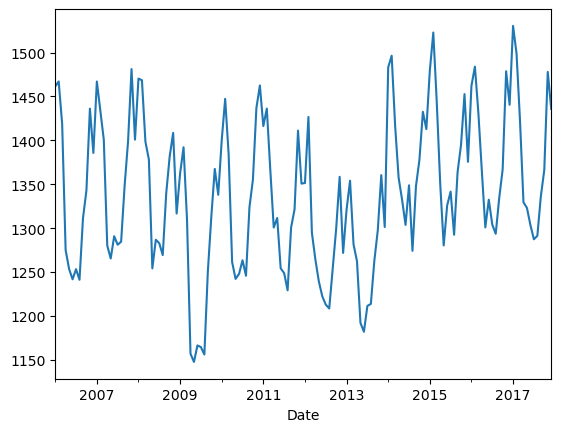

In [12]:
# Visualize the time series
ts.plot();

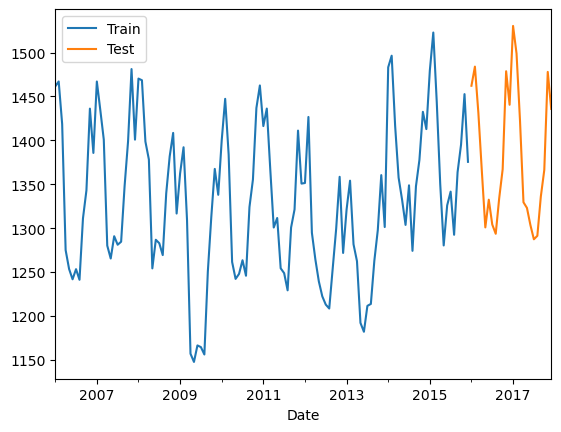

In [14]:
# tts so test size is 24 lags
test_lags = 24 
train, test = train_test_split(ts, test_size= test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

## Tune with pmdarima's auto_arima

In [15]:
import pmdarima as pm

# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=True,  
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1250.332, Time=1.55 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1411.678, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1264.720, Time=0.36 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1303.150, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2069.451, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=1249.069, Time=1.06 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=1250.756, Time=2.38 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=inf, Time=2.76 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=1254.012, Time=0.71 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(3,0,2)(1,0,0)[12] intercept   : AIC=1253.261, Time=1.41 sec
 ARIMA(2,0,3)(1,0,0)[12] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=1

In [16]:
# the auto_arima will store our best nonseasonal and seasonal orders separtely
print(auto_model.order)
print(auto_model.seasonal_order)

(1, 0, 1)
(1, 0, 0, 12)


## Fit a model on training data with the best parameters from auto_arima

In [17]:
# Orders for non seasonal components
p = 1 # nonseasonal AR
d = 0  # nonseasonal differencing
q = 1 # nonseasonal MA

# Orders for seasonal components
P = 1 # Seasonal AR
D = 0  # Seasonal differencing
Q = 0  # Seasonal MA
m = 12 # Seasonal period

auto_sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Or instead of manually defining the orders, you can obtain them programmatically
# auto_sarima = tsa.ARIMA(train, order = auto_model.order, seasonal_order = auto_model.seasonal_order)

# Obtain model summary
auto_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                       Consumption   No. Observations:                  120
Model:             ARIMA(1, 0, 1)x(1, 0, [], 12)   Log Likelihood                -610.218
Date:                           Wed, 29 Nov 2023   AIC                           1230.436
Time:                                   20:26:29   BIC                           1244.373
Sample:                               01-31-2006   HQIC                          1236.096
                                    - 12-31-2015                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1330.6538     60.650     21.940      0.000    1211.782    1449.525
ar.L1          0.8529      0.066     12.972      0.000       0.724       0.982
ma.L1         -0.1856      0.122     -1.526      0.127      -0.424       0.053
ar.S.L12       0.7791      0.062     12.502      0.000       0.657       0.901
sigma2      1378.4996    119.491     11.536      0.000    1144.301    1612.698
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                51.14
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                            -0.33
Prob(H) (two-sided):                  0.60   Kurtosis:                         6.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Plot the forecasts versus the test data

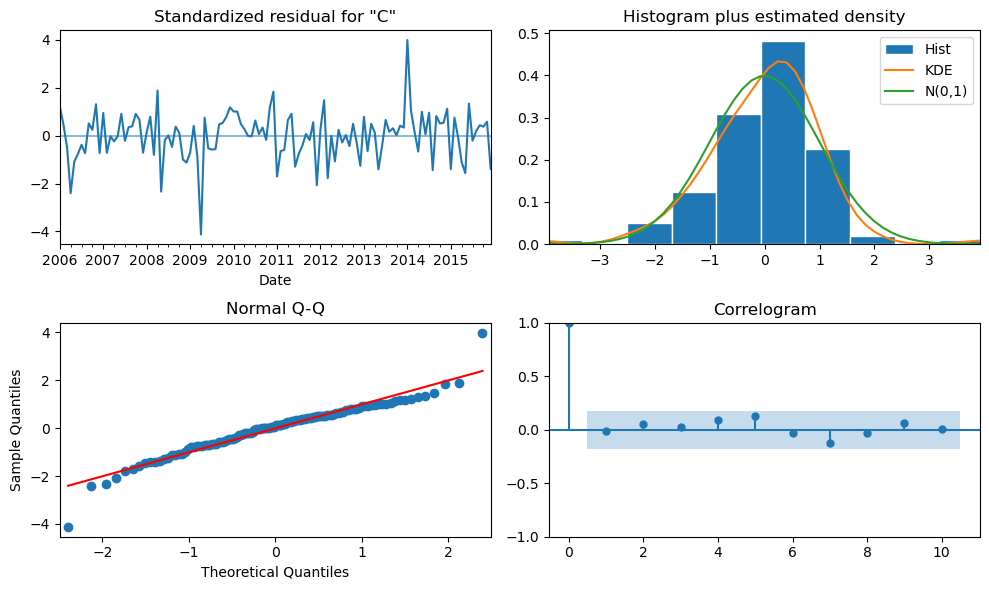

In [18]:
# Obtain diagnostic plots
fig = auto_sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

## Obtain metrics for evaluation

In [19]:
# Obtain summary of forecast as dataframe
forecast_df = auto_sarima.get_forecast(len(test)).summary_frame()

# Obtain metrics
regression_metrics_ts(test, forecast_df["mean"])

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 32.589
- MSE = 1,880.941
- RMSE = 43.370
- R^2 = 0.675
- MAPE = 2.29%


## Make forecasts with the auto_arima model

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Comparing Forecast vs. True Data'}, xlabel='Date'>)

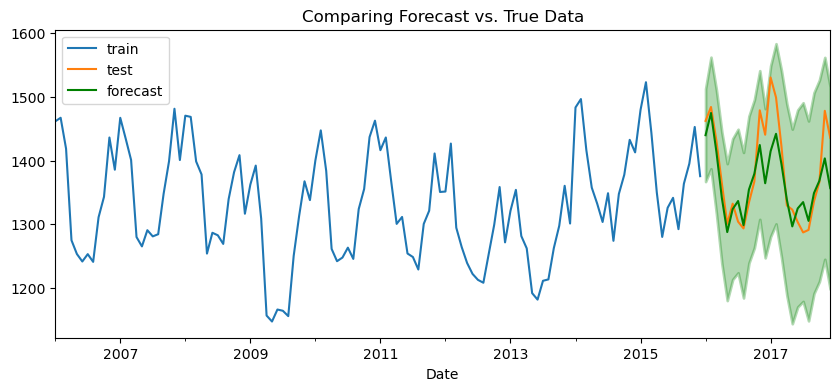

In [20]:
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)

## Select a final model

The models are similar. We ultimately chose the (1,0,1)(1,0,0,12) model recommended by the auto arima. It had better regression metrics and only slighlity higher AIC and BIC scores than the initial model.